# 1- Introduction

## 1.1 Problem statement

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

THe challenge is to build an NLP model to predict whether a Tweet is actually describing real emergency or not

## 1.2 Load the packages

In [130]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 

# nltk.download('stopwords')
# nltk.download('punkt')

from nltk.tokenize import word_tokenize
import re

import torch
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# Check if we have CUDA
print("CUDA device(s): " + str(torch.cuda.device_count()))

CUDA device(s): 0


/Users/mrakelinggara/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 1.3 Load the data

In [95]:
sample_submission = pd.read_csv("data/sample_submission.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

# 2. Preprocessing and EDA

In [96]:
print("Train data shape: " + str(train.shape))
print("Test data shape: " + str(test.shape))
print("Test/Train ratio: " +str(np.round(test.shape[0]/train.shape[0]*100, 2)) + "%")

Train data shape: (7613, 5)
Test data shape: (3263, 4)
Test/Train ratio: 42.86%


Ok, we have 7.6k rows of training data, and 3.2k rows of test data (~40% the size of the train data)

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Ok, so the `id` and `target` columns in the training dataset are good, no NULL values there, of course. Let's have a look at the other 3 columns.

In [98]:
train.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


## 2.1 "Clean" the Texts

In [99]:
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    #Change to lower case
    text = text.lower()
    #Handle &amp; special character and others
    text = text.replace("&amp;", " and ")
    text = text.replace("w/", " with ")
    
    #Remove/change mention
    text = re.sub(r'@\w+', 'xmention', text)
    #Remove/change url
    text = re.sub(r'http.?://[^\s]+[\s]?', 'xurl', text)
    #Points, hastags, commas, all kinds of symbols 
    text = re.sub(r'[^a-z0-9\s]', '', text)
    #Remove white spaces
    #text = re.sub("\n", ' ', text)
    text = text.replace("\n", " ")
    text = text.lstrip()
    text = text.rstrip()
    
    #Remove stopwords
    text = ' '.join([t for t in text.split() if t not in stop_words])
    
    return text

train['text_clean'] = [text_preprocess(t) for t in train.text.values]

list(set(train[train.target == 1].text_clean.values))[:10]

['map shows californias wildfires burning map created cal fire xurlxurl',
 'disaster averted police kill gunman hoax device cinema xurl',
 'calgarians stunned storm insurance companies busy handling calls abstorm xurl',
 'calgary pounded hail second day storms xurl',
 'police monitoring 200 jihadis poland xurlvia xmention',
 'mosque bombing strikes saudi special forces least 15 people dead suicide bomber struck mosque xurlnews',
 'deliver value cash source crash course xurlcourse xurl',
 '9 mile backup i77 southaccident blocking right 2 lanes exit 31 langtree rdconsider nc 115 nc 150 nc 16 alternate',
 'xmention lol natural disasterhospital crisis something needed get rid cast members',
 'xmention heavy rain hail']

In [100]:
train.text.shape, train.text_clean.shape, train.text.isnull().sum(), train.text_clean.isnull().sum()
train[train.text_clean.str.contains("how tough some people")]

,id,keyword,location,text,target,text_clean


In [101]:
train.keyword.value_counts().reset_index().rename(columns={'keyword':'N'})

,index,N
0,fatalities,45
1,armageddon,42
2,deluge,42
3,body%20bags,41
4,damage,41
...,...,...
216,forest%20fire,19
217,epicentre,12
218,threat,11
219,inundation,10


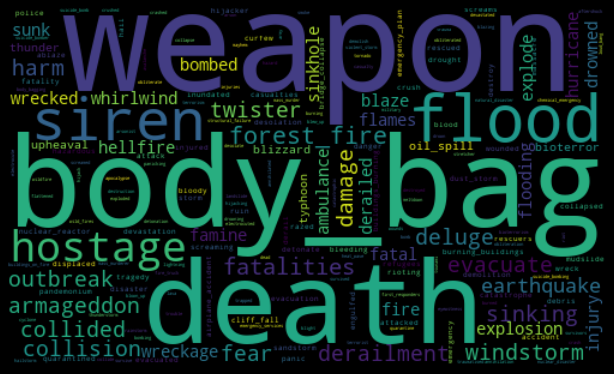

In [102]:
text = ' '.join(train.keyword.dropna().values).replace("%20", "_")
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [103]:
train.location.value_counts().reset_index().rename(columns={'location':'N'})

,index,N
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29
...,...,...
3336,"Manavadar, Gujarat",1
3337,"Charleston, WV",1
3338,"Silang, Cavite / ParaÌ±aque",1
3339,"Leicester, England",1


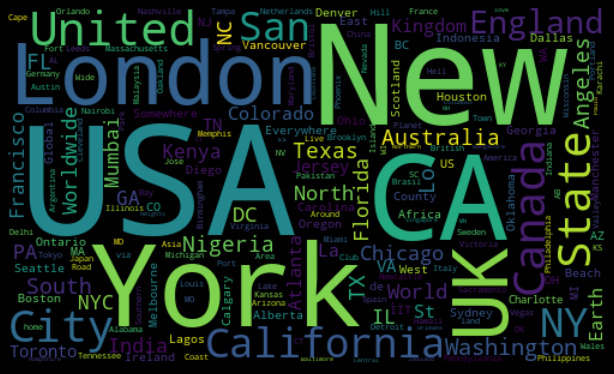

In [104]:
text = ' '.join(train.location.dropna().str.strip().replace(' ', "_").values).replace("%20", "_")
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Count if we have any retweets

In [105]:
temp = train.text.value_counts().reset_index()
temp = temp[temp.text > 1]
print(str(temp.shape[0]) + " unique texts - " + str(temp.text.sum()) + " tweets - " + str(np.round(temp.text.sum()/train.shape[0]*100, 2)) + "% of train data")

69 unique texts - 179 tweets - 2.35% of train data


## 2.1 Check to see if there are any big differences in disaster tweets and non-disaster tweets

In [106]:
list(set(train[train.target == 1].text_clean.values))[:10]

['map shows californias wildfires burning map created cal fire xurlxurl',
 'disaster averted police kill gunman hoax device cinema xurl',
 'calgarians stunned storm insurance companies busy handling calls abstorm xurl',
 'calgary pounded hail second day storms xurl',
 'police monitoring 200 jihadis poland xurlvia xmention',
 'mosque bombing strikes saudi special forces least 15 people dead suicide bomber struck mosque xurlnews',
 'deliver value cash source crash course xurlcourse xurl',
 '9 mile backup i77 southaccident blocking right 2 lanes exit 31 langtree rdconsider nc 115 nc 150 nc 16 alternate',
 'xmention lol natural disasterhospital crisis something needed get rid cast members',
 'xmention heavy rain hail']

In [107]:
list(set(train[train.target == 0].text_clean.values))[:10]

['stop panicking xmention xurl',
 'ball curfew xurl',
 'beach reads august giveaway hop xmention giving away book mayhem series xurl',
 'xmention pets r like part family love animals last 2 pets rescued breaks heart animals mistreated',
 'survive ill see tomorrow',
 'jumps cliff drinking tea british people fall cliffs',
 'peeped frontin jeepsunk seat tinted heat beats bumpin',
 'sex workers say credit card bans online ads harm good xurl',
 'able touch anything anyone penneys without electrocuted',
 'message sent dont reply see saw message least tell fuck something']

### 2.1.2 Check tweet length

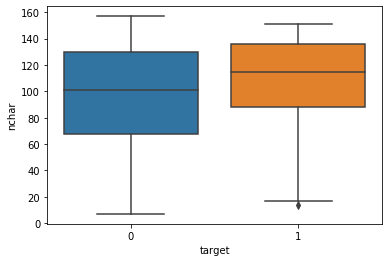

In [108]:
train['nchar'] = [len(t) for t in train.text.values]
# print(train.nchar.describe())
# print(train[train.target == 0].nchar.describe())
# print(train[train.target == 1].nchar.describe())
# sns.distplot(train[train.target == 0][['nchar']], hist=False, rug=True)
# sns.distplot(train[train.target == 1][['nchar']], hist=False, rug=True)
sns.boxplot(x="target", y = "nchar", data=train)
plt.show()

We can see that Disaster tweets tend to be longer than Non-disaster tweets. There are also some tweets with more than 140 characters, this is because of the use of emojis.

In [109]:
print(train[train.nchar > 150].text.values)
print()
print(train[train.nchar > 150].text_clean.values)

['@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP'
 "when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"
 "It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally made a loud bang&amp;my dad(who has a broken leg)walked-"]

['xmention 90blks 8whts colluded 2 take wht f xmention auth hostage 2 make look blk bioterrorism use lglorg idis id still hersxmention'
 'youre taking shower someone flushes toilet 1 second gtfo get burned'
 '230 morning went downstairs watch telly accidentally made loud bang dadwho broken legwalked']


### 2.1.3 VADER Sentiment

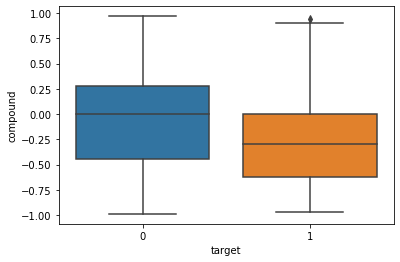

In [110]:
# import nltk
# nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

train['sid'] = [sid.polarity_scores(t) for t in train.text_clean.values]
train['compound'] = [d['compound'] for d in train.sid.values]

sns.boxplot(x='target', y='compound', data=train)

Ok, so we can see that VADER detects the disaster tweets as more negative than the non disaster tweets

## 2.2 Tokenizing text

In [111]:
count_vect = CountVectorizer()
texts = train['text_clean'].values
temp = count_vect.fit_transform(texts)
temp.shape

(7613, 15653)

In [112]:
tfidf_transformer = TfidfTransformer()
temp_2 = tfidf_transformer.fit_transform(temp)
temp_2.shape

(7613, 15653)

In [113]:
vectorizer = TfidfVectorizer()
temp_vect = vectorizer.fit_transform(texts)
temp_vect.shape

(7613, 15653)

In [114]:
train['tokens'] = train.text_clean.apply(lambda t:word_tokenize(t))
# train['tokens'] = train['tokens'].values[0]
# train[['tokens']].values[0][0]

In [115]:
train['tokens'].values

array([list(['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']),
       ..., list(['m194', '0104', 'utc5km', 'volcano', 'hawaii', 'xurl']),
       list(['police', 'investigating', 'ebike', 'collided', 'car', 'little', 'portugal', 'ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['latest', 'homes', 'razed', 'northern', 'california', 'wildfire', 'abc', 'news', 'xurl'])],
      dtype=object)

In [116]:
train.text_clean.values[0], train.text.values[0] 

('deeds reason earthquake may allah forgive us',
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

# 3. Train/test split and Model Creation

In [117]:
tweet_train, tweet_test, target_train, target_test = train_test_split(train['text_clean'], train['target'], test_size=0.25, random_state=42)

print("Train Features\t: " + str(tweet_train.shape))
print("Train Target\t: " + str(target_train.shape) + "\tLabel 1 (%): " + str(np.round(target_train.sum()/target_train.shape[0]*100, 2)))
print("Test Features\t: " + str(tweet_test.shape))
print("Test Target\t: " + str(target_test.shape) + "\tLabel 1 (%): " + str(np.round(target_test.sum()/target_test.shape[0]*100, 2)))


Train Features	: (5709,)
Train Target	: (5709,)	Label 1 (%): 43.05
Test Features	: (1904,)
Test Target	: (1904,)	Label 1 (%): 42.7


### 3.1 SVC

In [118]:
#SVM parameters
parameteres = {'classifier__C':[0.001,0.1,10,100], 'classifier__gamma':[0.1,0.01], 
              'classifier__kernel': ['linear', 'poly', 'rbf']}

pipeline_svc = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', SVC()),
#    ('classifier', LogisticRegression())
])

grid_svc = GridSearchCV(pipeline_svc, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=2) 

print("Model initialized====")

grid_svc.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_svc.score(tweet_test,target_test)))
print (grid_svc.best_params_)

Model initialized====
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   40.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:  1.8min finished


Model trained====
score = 0.80
{'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


In [119]:
predictions = grid_svc.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1091
           1       0.78      0.75      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904

[[918 173]
 [205 608]]
0.8014705882352942


In [120]:
grid_svc.predict(["this forest fire is scary"])

array([1])

## 3.2 MultinomialNB

In [121]:
#MultinomialNB parameters
parameteres = {'classifier__alpha':[0.001,0.1,0.25, 0.5, 0.75, 0.8, 0.9, 1]}

pipeline_mnb = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', MultinomialNB())
])

grid_mnb = GridSearchCV(pipeline_mnb, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=5) 

print("Model initialized====")

grid_mnb.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_mnb.score(tweet_test,target_test)))
print (grid_mnb.best_params_)

Model initialized====
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.1s


Model trained====
score = 0.80
{'classifier__alpha': 0.5}


[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed:    1.5s finished


In [122]:
predictions = grid_mnb.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))
print(grid_mnb.predict(["this forest fire is scary"]))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1091
           1       0.82      0.69      0.75       813

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

[[963 128]
 [248 565]]
0.8025210084033614
[1]


### 3.3 Logistic Regression

In [123]:
#Logistic Regression parameters
parameteres = {'classifier__C':[0.001,0.1,0.25, 0.5, 0.75, 0.8, 0.9, 1.0], 
              'classifier__solver':['newton-cg', 'sag', 'lbfgs'], 
              'classifier__max_iter':[100,200,500,1000]}

pipeline_lr = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', LogisticRegression())
])

grid_lr = GridSearchCV(pipeline_lr, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=5) 

print("Model initialized====")

grid_lr.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_lr.score(tweet_test,target_test)))
print (grid_lr.best_params_)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Model initialized====
Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 132 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done 312 tasks      | elapsed:   25.4s


Model trained====
score = 0.81
{'classifier__C': 1.0, 'classifier__max_iter': 100, 'classifier__solver': 'newton-cg'}


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:   31.3s finished


In [124]:
predictions = grid_lr.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))
print(grid_lr.predict(["this forest fire is scary"]))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1091
           1       0.84      0.69      0.76       813

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904

[[982 109]
 [251 562]]
0.8109243697478992
[1]


### 3.4 Random Forest

In [128]:
#Logistic Regression parameters
parameteres = {
    'tfidf__max_features':[2000],
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
 'classifier__max_depth': [1000],
 'classifier__min_samples_split': [10, 50, 100],
 'classifier__max_leaf_nodes': [None]}

pipeline_rf = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipeline_rf, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=5) 

print("Model initialized====")

grid_rf.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_rf.score(tweet_test,target_test)))
print (grid_rf.best_params_)

Model initialized====
Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:   10.3s finished


Model trained====
score = 0.78
{'classifier__max_depth': 1000, 'classifier__max_leaf_nodes': None, 'classifier__min_samples_split': 100, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 3)}


/Users/mrakelinggara/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [129]:
predictions = grid_rf.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))
print(grid_rf.predict(["this forest fire is scary"]))

              precision    recall  f1-score   support

           0       0.78      0.86      0.81      1091
           1       0.78      0.67      0.72       813

    accuracy                           0.78      1904
   macro avg       0.78      0.76      0.77      1904
weighted avg       0.78      0.78      0.77      1904

[[934 157]
 [268 545]]
0.7767857142857143
[1]


## 4. Save Models

In [131]:
joblib.dump(grid_lr, 'grid_lr.pkl')
joblib.dump(grid_mnb, 'grid_mnb.pkl')
joblib.dump(grid_rf, 'grid_rf.pkl')
joblib.dump(grid_svc, 'grid_svc.pkl')

['grid_svc.pkl']